# CNN Model

In [1]:
# Required imports:

import datetime
import os 
import shutil
import sys

import numpy as np
import pandas as pd
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import matplotlib.pyplot as plt

sys.path.append(os.path.join("..", "code"))
from cnn_model import *
from tif_files import TifFile, TifDir
from utils import get_y_data, open_y_data, sat_img_filelist_df

pd.set_option("display.max_colwidth", 500)


DIR = os.getcwd()
DATA_DIR = os.path.join(os.path.dirname(DIR), "data")
TRAIN_DIR = os.path.join(DATA_DIR, "training_data")
DEV_DIR = os.path.join(DATA_DIR, "img_dir")

2022-11-12 15:29:22.492218: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Put some data in the training dir

In [2]:
gage = "11402000"
band = "total_precipitation"
date_from = "2010_01_01"
date_to = "2010_12_31"

In [3]:
fp = os.path.join(TRAIN_DIR, "raw", gage)
files = [f for f in os.listdir(fp) if f.endswith(".tif")]
files_df = sat_img_filelist_df(files)

In [4]:
dt_from = datetime.datetime.strptime(date_from, DATE_FORMAT)
dt_to = datetime.datetime.strptime(date_to, DATE_FORMAT)

In [5]:
# Filter to files to copy over:
files_for_training = files_df[
    (files_df["band"] == band) &
    (files_df["date"] >= dt_from) &
    (files_df["date"] <= dt_to)
]
files_for_training.head()

,filename,filename_ext,filename_prefix,subdir,crs,scale,satellite,band,date_str,date
5,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_05_16.tif,tif,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_05_16,,11402000#EPSG_4326,11131.95,ECMWF_ERA5_LAND_HOURLY,total_precipitation,2010_05_16,2010-05-16
6,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_05_02.tif,tif,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_05_02,,11402000#EPSG_4326,11131.95,ECMWF_ERA5_LAND_HOURLY,total_precipitation,2010_05_02,2010-05-02
7,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_02_23.tif,tif,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_02_23,,11402000#EPSG_4326,11131.95,ECMWF_ERA5_LAND_HOURLY,total_precipitation,2010_02_23,2010-02-23
11,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_12_26.tif,tif,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_12_26,,11402000#EPSG_4326,11131.95,ECMWF_ERA5_LAND_HOURLY,total_precipitation,2010_12_26,2010-12-26
15,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_10_23.tif,tif,11402000#EPSG_4326__11131_95__ECMWF_ERA5_LAND_HOURLY__total_precipitation__2010_10_23,,11402000#EPSG_4326,11131.95,ECMWF_ERA5_LAND_HOURLY,total_precipitation,2010_10_23,2010-10-23


In [6]:
# Empty out current contents of training source dir:
for f in os.listdir(DEV_DIR):
    if f.endswith(".tif"):
        fp = os.path.join(DEV_DIR, f)
        os.remove(fp)

In [7]:
for ix, row in files_for_training.iterrows():
    src_fn = row["filename"]
    src = os.path.join(TRAIN_DIR, "raw", gage, src_fn)
    dest_fn = f"{gage}#{src_fn}"
    dest = os.path.join(DEV_DIR, dest_fn)
    shutil.copyfile(src, dest)

In [8]:
files_df = sat_img_filelist_df(os.listdir(DEV_DIR))
files_df["gage"] = files_df["crs"].map(lambda s: s.split("#")[0])
files_df["crs"] = files_df["crs"].map(lambda s: s.split("#")[-1])

## Sample images

In [9]:
tifs = TifDir(DEV_DIR)

fps = dict(enumerate(tifs.tif_fps))

In [10]:
# # Example gage 11266500 image:
# ix = [k for k, v in fps.items() if "11266500" in v]
# sample_temp_img = tifs[ix[0]]
# sample_temp_img.plot()

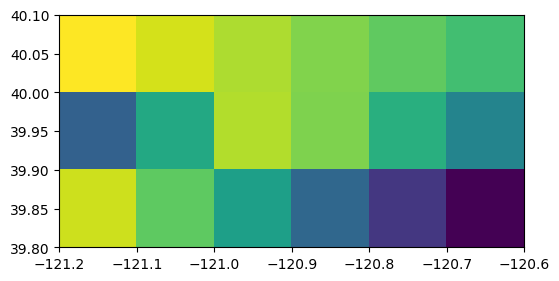

In [11]:
# Example gage 11402000 image:
ix = [k for k, v in fps.items() if "11402000" in v]
sample_temp_img = tifs[ix[0]]
sample_temp_img.plot()

## Calculate image normalization values

In [12]:
files = [f for f in  os.listdir(DEV_DIR) if f.endswith(".tif")]
img_fp = [os.path.join(DEV_DIR, f) for f in files]

In [13]:
def pixel_mean_std(*img_fp):
    """Calculate mean and STD of all image pixels across multiple images."""
    # Source: https://kozodoi.me/python/deep%20learning/pytorch/tutorial/2021/03/08/image-mean-std.html
    total_count = len(img_fp)
    total_img_sum = 0
    total_img_sum_sq = 0
    total_num_pixels = 0

    for fp in img_fp:
        tif = TifFile(fp)
        img_sum = tif.as_numpy.sum()
        total_img_sum += img_sum
        img_sum_sq = (tif.as_numpy ** 2).sum()
        total_img_sum_sq += img_sum_sq
        total_num_pixels += tif.num_pixels

    pixel_mean = total_img_sum / total_num_pixels
    pixel_var  = (total_img_sum_sq / total_num_pixels) - (pixel_mean ** 2)
    pixel_std  = np.sqrt(pixel_var)

    return {"pixel_mean": pixel_mean, "pixel_std": pixel_std}

In [14]:
norm_values = pixel_mean_std(*img_fp)
norm_values

{'pixel_mean': 0.05085699993716811, 'pixel_std': 0.11708163676291265}

## Prepare y-data

In [15]:
y = open_y_data()
y["gage"] = y["gage"].astype(str)
y_df = pd.pivot_table(y, columns=["gage"], index="time", values="m3", aggfunc="mean")
y_df.index = pd.to_datetime(y_df.index)
y_df.tail()

gage,11185500,11189500,11202710,11208000,11266500,11318500,11402000
time,,,,,,,
2018-09-26,1.217624,0.080986,0.622971,0.127426,0.563505,0.136204,0.654119
2018-09-27,1.217624,0.078721,0.594654,0.127426,0.555010,0.132240,0.645624
2018-09-28,1.217624,0.084667,0.594654,0.124594,0.543683,0.129691,0.591822
2018-09-29,1.217624,0.088349,0.622971,0.127426,0.535188,0.132240,0.492713
2018-09-30,0.566337,0.094578,0.622971,0.127426,0.532357,0.141867,0.521030


In [16]:
y_series = y_df.loc[(y_df.index >= dt_from) & (y_df.index <= (dt_to + datetime.timedelta(days=1))), gage]
y_mean, y_std = np.mean(y_series), np.std(y_series)
y_norm = (y_series - y_mean) / y_std

## Create dataset generator

In [17]:
tifs = TifDir(DEV_DIR)

def image_gen():
    for tif in tifs:
        array = tif.as_numpy
        norm_array = (array - norm_values["pixel_mean"]) / norm_values["pixel_std"]
        file_metadata = files_df[files_df["filename"] == tif.fp.split("/")[-1]].iloc[0]
        y_value = y_norm.loc[file_metadata["date"] + datetime.timedelta(days=1)]
        yield np.expand_dims(np.expand_dims(norm_array, 0), -1), np.expand_dims(np.array(y_value), 0)

In [18]:
train_data = tf.data.Dataset.from_generator(
    image_gen, 
    output_signature=(tf.TensorSpec(shape=(None, None, None, 1), dtype=tf.float32),
                      tf.TensorSpec(shape=(1), dtype=tf.float32))
)

2022-11-12 15:29:33.706264: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


## CNN model - 1 image input, 1 scalar output

Simple CNN architecture to take in images of different sizes and convert to same length vectors with global pooling.

In [19]:
inputs = keras.Input(shape=(None, None, 1), batch_size=None, name="img")
x = layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation=None)(inputs)
x = layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)(x)
x = layers.Dense(16, activation="relu")(x)
outputs = layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img (InputLayer)            [(None, None, None, 1)]   0         
                                                                 
 conv2d (Conv2D)             (None, None, None, 16)    80        
                                                                 
 global_average_pooling2d (G  (None, 16)               0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 16)                272       
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 369
Trainable params: 369
Non-trainable params: 0
_______________________________________________________________

In [20]:
opt = keras.optimizers.Adam(learning_rate=0.0001)
model.compile(optimizer=opt, loss="mean_squared_error")
model.fit(train_data, epochs=15, batch_size=8)

Epoch 1/15
365/365 [==============================] - 2s 5ms/step - loss: 0.8585
Epoch 2/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8433
Epoch 3/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8326
Epoch 4/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8267
Epoch 5/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8240
Epoch 6/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8222
Epoch 7/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8209
Epoch 8/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8199
Epoch 9/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8192
Epoch 10/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8185
Epoch 11/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8179
Epoch 12/15
365/365 [==============================] - 1s 3ms/step - loss: 0.8174
Epoch 13/15
365/365 [====

## CNN model - image sequence input + Global Average Pooling

Similar to simple model above, but inputs are a sequence of images e.g. 1 week's data for a single satellite source.

In [21]:
# First number 7 is number of images in sequence:
inputs = keras.Input(shape=(7, None, None, 1), batch_size=None, name="img_seq")
conv_2d_layer = layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation=None)
x = layers.TimeDistributed(conv_2d_layer, name="conv2d")(inputs)
pooling_layer = layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)
outputs = layers.TimeDistributed(pooling_layer, name="global_pooling")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_seq (InputLayer)        [(None, 7, None, None, 1  0         
                             )]                                  
                                                                 
 conv2d (TimeDistributed)    (None, 7, None, None, 16  80        
                             )                                   
                                                                 
 global_pooling (TimeDistrib  (None, 7, 16)            0         
 uted)                                                           
                                                                 
Total params: 80
Trainable params: 80
Non-trainable params: 0
_________________________________________________________________


## Transformer Encoder

In [22]:
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim, activation="relu"),
             layers.Dense(embed_dim),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(
            inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

    
# First number 7 is number of images in sequence:
inputs = keras.Input(shape=(7, None, None, 1), batch_size=None, name="img_seq")
conv_2d_layer = layers.Conv2D(filters=16, kernel_size=(2, 2), strides=(1, 1), activation=None)
x = layers.TimeDistributed(conv_2d_layer, name="conv2d")(inputs)
pooling_layer = layers.GlobalAveragePooling2D(data_format="channels_last", keepdims=False)
x = layers.TimeDistributed(pooling_layer, name="global_pooling")(x)
outputs = TransformerEncoder(embed_dim=16, dense_dim=32, num_heads=2)(x)

# outputs = layers.Dense(14, activation="relu")(x)
# outputs = layers.Dense(1, activation="linear")(x)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_seq (InputLayer)        [(None, 7, None, None, 1  0         
                             )]                                  
                                                                 
 conv2d (TimeDistributed)    (None, 7, None, None, 16  80        
                             )                                   
                                                                 
 global_pooling (TimeDistrib  (None, 7, 16)            0         
 uted)                                                           
                                                                 
 transformer_encoder (Transf  (None, 7, 16)            3296      
 ormerEncoder)                                                   
                                                                 
Total params: 3,376
Trainable params: 3,376
Non-trainable p